## read raw data

In [4]:
from loguru import logger
from transformers import AutoTokenizer
from torchtext.data import get_tokenizer
import os
from datasets import load_dataset,load_from_disk
import numpy as np

class Options:
    def __init__(self, name) -> None:
        self.name= name
    def name(self):
        return self.name

# project gloal parameter
options = Options("Model")
options.base_path="/home/yang/github/fuzzys2s/"
options.SOS = 0 # start of sentence
options.EOS = 1 # End of sentence
options.PAD = 2 # padding token
options.UNK = 3 # unknown token, word frequency low

class Vocab:
    def __init__(self, name):
        self.name = name
        self.word2index = {"<sos>":options.SOS, "<eos>":options.EOS, "<pad>":options.PAD,"<unk>":options.UNK}
        self.word2count = {"<sos>":1, "<eos>":1, "<pad>":1,"<unk>":1}
        self.index2word = {options.SOS: "<sos>", options.EOS: "<eos>", options.PAD:"<pad>",options.UNK: "<unk>"}
        self.n_words = 4  # Count PAD , SOS and EOS
        self.feature_max = [] # max value of feature
        self.feature_min = [] # min value of feature
        self.line_max = 0 # max length of sentence

    def addTokens(self, tokens):
        for word in tokens:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def build_vocab(vocab_src, vocab_tgt, tokens):
    for sentence in tokens:
        src = sentence[0]
        tgt = sentence[1]
        vocab_src.addTokens(src)
        vocab_tgt.addTokens(tgt)
        if len(src) > vocab_src.line_max:
            vocab_src.line_max = len(src)
        if len(tgt) > vocab_tgt.line_max:
            vocab_tgt.line_max = len(tgt)
    return vocab_src, vocab_tgt

def get_base_tokenizer(name):
    tokenizer_path = options.base_path+"output/"+name+"/"
    if os.path.exists(tokenizer_path):
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    else:
        tokenizer = AutoTokenizer.from_pretrained(name)
        tokenizer.save_pretrained(tokenizer_path)
    return tokenizer.tokenize

def gen_token_vectors(vocab_src, vocab_tgt, tokens):
    token_vectors =[]
    for row in tokens:
        src = [vocab_src.word2index[word]  for word in row[0]]
        tgt = [vocab_tgt.word2index[word]  for word in row[1]]
        token_vectors.append([src, tgt])
    return token_vectors

def read_raw_tokens(dataset, src_lang, tgt_lang, tokenizer):
    train_len = 200000#dataset['train'].num_rows
    test_len = 2000#dataset['test'].num_rows
    valid_len = 2000#dataset['validation'].num_rows
    train_raw_tokens = np.empty([train_len], dtype=int).tolist()
    train_iter = iter(dataset['train'])
    for i in range(train_len):
        data = next(train_iter)
        src = data['translation'][src_lang]
        tgt = data['translation'][tgt_lang]
        src = tokenizer(src)
        tgt = tokenizer(tgt)
        train_raw_tokens[i] = [src, tgt]
    test_raw_tokens = np.empty([test_len], dtype=int).tolist()
    test_iter = iter(dataset['test'])
    for i in range(test_len):
        data = next(test_iter)
        src = data['translation'][src_lang]
        tgt = data['translation'][tgt_lang]
        src = tokenizer(src)
        tgt = tokenizer(tgt)
        test_raw_tokens[i] = [src, tgt]
    valid_raw_tokens = np.empty([test_len], dtype=int).tolist()
    valid_iter = iter(dataset['validation'])
    for i in range(valid_len):
        data = next(valid_iter)
        src = data['translation'][src_lang]
        tgt = data['translation'][tgt_lang]
        src = tokenizer(src)
        tgt = tokenizer(tgt)
        valid_raw_tokens[i] = [src, tgt]
    return train_raw_tokens, test_raw_tokens, valid_raw_tokens

def read_dataset(name, subpath):
    dataset_path = options.base_path+"output/"+name+"/"+subpath+"/"
    if os.path.exists(dataset_path):
        dataset = load_from_disk(dataset_path)
    else :
        if subpath == '':
            dataset = load_dataset(name)
        else:
            dataset = load_dataset(name,subpath)
        dataset.save_to_disk(dataset_path)
    print(name,'-',subpath,'done')


def read_wmt14_data(tokenizer):
    logger.info("read wmt14 data")
    src_lang = 'en'
    tgt_lang = 'fr'
    dataset = read_dataset('wmt14', 'fr-en')
    logger.info("read raw tokens")
    train_tokens, test_tokens,valid_tokens = read_raw_tokens(dataset, src_lang, tgt_lang, tokenizer)
    logger.info("build vocabulary")
    vocab_src = Vocab("src en")
    vocab_tgt = Vocab("tgt fr")
    build_vocab(vocab_src, vocab_tgt, train_tokens)
    build_vocab(vocab_src, vocab_tgt, valid_tokens)
    build_vocab(vocab_src, vocab_tgt, test_tokens)
    logger.info("src vocab name:%s, size:%d" %(vocab_src.name, vocab_src.n_words))
    logger.info("tgt vocab name:%s, size:%d" %(vocab_tgt.name, vocab_tgt.n_words))
    logger.info("generate token vectors")
    train_data = gen_token_vectors(vocab_src, vocab_tgt, train_tokens)
    valid_data = gen_token_vectors(vocab_src, vocab_tgt, valid_tokens)
    test_data = gen_token_vectors(vocab_src, vocab_tgt, test_tokens)
    return train_data, valid_data, test_data, vocab_src, vocab_tgt

## plot sub_graph

2023-05-09 12:14:15.940 | INFO     | __main__:read_wmt14_data:122 - read wmt14 data
Found cached dataset wmt14 (/home/yang/.cache/huggingface/datasets/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)


  0%|          | 0/3 [00:00<?, ?it/s]

2023-05-09 12:14:19.667 | INFO     | __main__:read_wmt14_data:126 - read raw tokens
2023-05-09 12:14:26.349 | INFO     | __main__:read_wmt14_data:128 - build vocabulary
2023-05-09 12:14:28.448 | INFO     | __main__:read_wmt14_data:134 - src vocab name:src en, size:45181
2023-05-09 12:14:28.449 | INFO     | __main__:read_wmt14_data:135 - tgt vocab name:tgt fr, size:58663
2023-05-09 12:14:28.450 | INFO     | __main__:read_wmt14_data:136 - generate token vectors
2023-05-09 12:14:31.385 | INFO     | __main__:read_wmt14_data:122 - read wmt14 data
Found cached dataset wmt14 (/home/yang/.cache/huggingface/datasets/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)


  0%|          | 0/3 [00:00<?, ?it/s]

2023-05-09 12:14:35.859 | INFO     | __main__:read_wmt14_data:126 - read raw tokens
2023-05-09 12:15:12.379 | INFO     | __main__:read_wmt14_data:128 - build vocabulary
2023-05-09 12:15:14.574 | INFO     | __main__:read_wmt14_data:134 - src vocab name:src en, size:20900
2023-05-09 12:15:14.574 | INFO     | __main__:read_wmt14_data:135 - tgt vocab name:tgt fr, size:11269
2023-05-09 12:15:14.575 | INFO     | __main__:read_wmt14_data:136 - generate token vectors
2023-05-09 12:15:17.732 | INFO     | __main__:read_wmt14_data:122 - read wmt14 data
Found cached dataset wmt14 (/home/yang/.cache/huggingface/datasets/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)


  0%|          | 0/3 [00:00<?, ?it/s]

2023-05-09 12:15:21.068 | INFO     | __main__:read_wmt14_data:126 - read raw tokens
2023-05-09 12:15:58.672 | INFO     | __main__:read_wmt14_data:128 - build vocabulary
2023-05-09 12:16:00.871 | INFO     | __main__:read_wmt14_data:134 - src vocab name:src en, size:3313
2023-05-09 12:16:00.872 | INFO     | __main__:read_wmt14_data:135 - tgt vocab name:tgt fr, size:3488
2023-05-09 12:16:00.873 | INFO     | __main__:read_wmt14_data:136 - generate token vectors


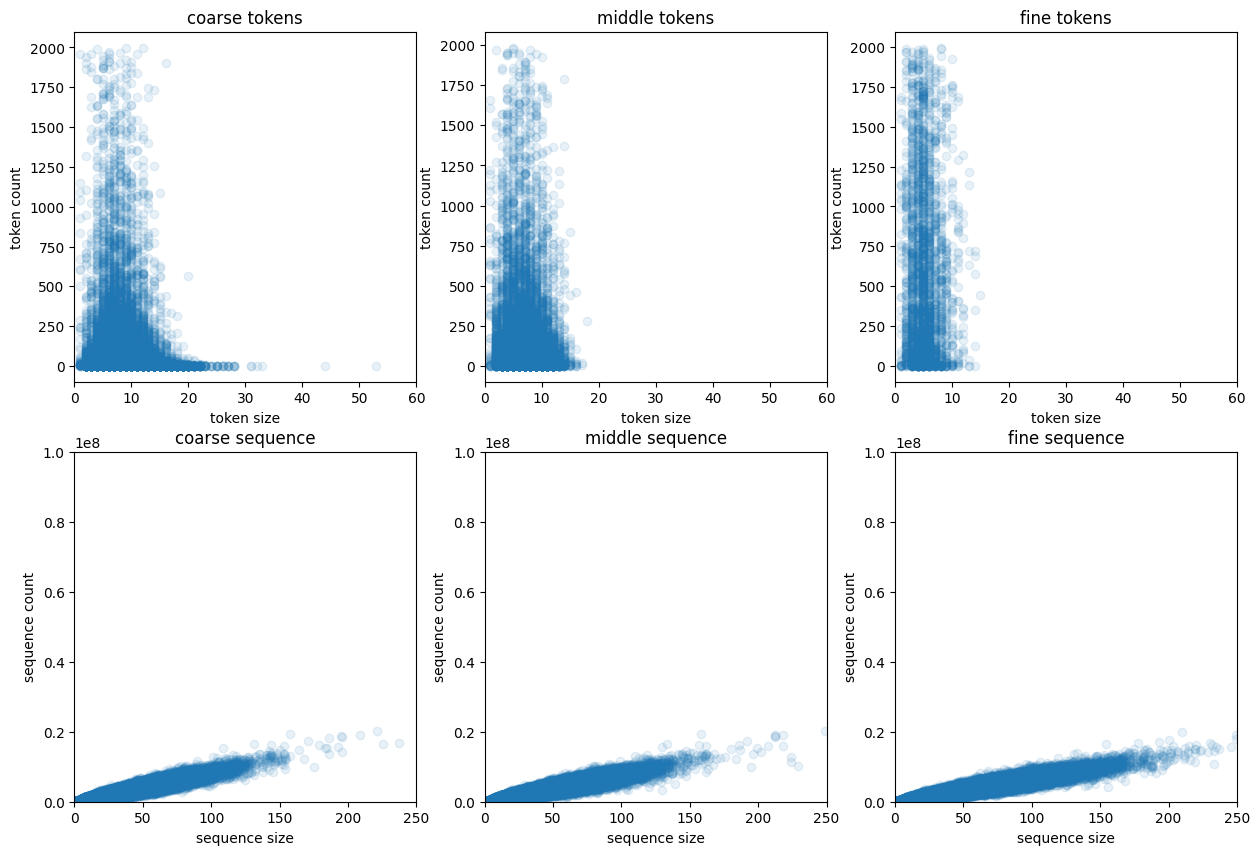

In [14]:
from matplotlib import pyplot as plt
import numpy as np
logger.add(options.base_path+'output/wmt-analyze.log')
count_limit = 100
def get_seq_count(seq, vocab):
    seq_count = 0
    for idx in seq:
        token = vocab.index2word[idx]
        seq_count = seq_count + vocab.word2count[token]
    return seq_count

def read_data(tokenizer):
    train_data, valid_data, test_data, vocab_src, vocab_tgt=read_wmt14_data(tokenizer)
    src_data = []
    for i in range(vocab_src.n_words):
        word = vocab_src.index2word[i]
        count = vocab_src.word2count[word]
        if count > count_limit:
            continue
        src_data.append([len(word), count])
    src_data = np.array(src_data)
    tgt_data = []
    for i in range(vocab_tgt.n_words):
        word = vocab_tgt.index2word[i]
        count = vocab_tgt.word2count[word]
        if count > count_limit:
            continue
        tgt_data.append([len(word), count])
    tgt_data = np.array(tgt_data)
    
    src_seq = np.empty((len(train_data), 2))
    tgt_seq = np.empty((len(train_data), 2))
    for i in range(len(train_data)):
        src = train_data[i][0]
        tgt = train_data[i][1]
        src_len = len(src)
        tgt_len = len(tgt)
        src_count = get_seq_count(src, vocab_src)
        tgt_count = get_seq_count(tgt, vocab_tgt)
        src_seq[i][0] = src_len
        src_seq[i][1] = src_count
        tgt_seq[i][0] = tgt_len
        tgt_seq[i][1] = tgt_count
    return src_data, tgt_data, src_seq, tgt_seq

tokenizer = get_tokenizer("basic_english")
coarse_src_data, coarse_tgt_data, coarse_src_seq, coarse_tgt_seq = read_data(tokenizer)
tokenizer = get_base_tokenizer('bert-base-uncased')
middle_src_data,middle_tgt_data, middle_src_seq,middle_tgt_seq = read_data(tokenizer)
tokenizer = get_base_tokenizer('vs4000_wmt14_tokenizer')
fine_src_data,fine_tgt_data, fine_src_seq,fine_tgt_seq = read_data(tokenizer)


f, axes = plt.subplots(2, 3, figsize=(15,10))

sub_graph = axes[0][0]
data = coarse_tgt_data
sub_graph.scatter(data[:,0], data[:,1], alpha=.1)
sub_graph.set_title("coarse tokens")
sub_graph.set_xlabel("token size")
sub_graph.set_ylabel("token count")
sub_graph.set_xlim((0,60))

sub_graph = axes[0][1]
data = middle_src_data
sub_graph.scatter(data[:,0], data[:,1], alpha=.1)
sub_graph.set_title("middle tokens")
sub_graph.set_xlabel("token size")
sub_graph.set_ylabel("token count")
sub_graph.set_xlim((0,60))

sub_graph = axes[0][2]
data = fine_src_data
sub_graph.scatter(data[:,0], data[:,1], alpha=.1)
sub_graph.set_title("fine tokens")
sub_graph.set_xlabel("token size")
sub_graph.set_ylabel("token count")
sub_graph.set_xlim((0,60))

sub_graph = axes[1][0]
data = coarse_src_seq
sub_graph.scatter(data[:,0], data[:,1], alpha=.1)
sub_graph.set_title("coarse sequence")
sub_graph.set_xlabel("sequence size")
sub_graph.set_ylabel("sequence count")
sub_graph.set_xlim((0,250))
sub_graph.set_ylim((0,100000000))

sub_graph = axes[1][1]
data = middle_src_seq
sub_graph.scatter(data[:,0], data[:,1], alpha=.1)
sub_graph.set_title("middle sequence")
sub_graph.set_xlabel("sequence size")
sub_graph.set_ylabel("sequence count")
sub_graph.set_xlim((0,250))
sub_graph.set_ylim((0,100000000))

sub_graph = axes[1][2]
data = fine_src_seq
sub_graph.scatter(data[:,0], data[:,1], alpha=.1)
sub_graph.set_title("fine sequence")
sub_graph.set_xlabel("sequence size")
sub_graph.set_ylabel("sequence count")
sub_graph.set_xlim((0,250))
sub_graph.set_ylim((0,100000000))

plt.show()